In [1]:
import torch
from model_triton import *

dloss_dx = torch.randn((8, 512, 768), device="cuda")
#Two shapes are being used: [8, 12, 512, 512], and 4096, 35374
aa = torch.randn((8, 512, 768), device="cuda")
#aa = torch.randn((4096, 35374), device="cuda")
#aa = aa.view(-1)
N = 100

from functools import partial
fn_naive = partial(t_dropout_bkwd2, train=True, p_gen_aux=42)
fn_jit = torch.compile(fn_naive)
# burn it
#fn_jit(aa) 
fn_jit(dloss_dx, aa) 

from torch.profiler import profile, record_function, ProfilerActivity, schedule
activities = [ProfilerActivity.CPU, ProfilerActivity.CUDA]
with profile(activities=activities, record_shapes=True) as prof:
    for _ in range(N):
        #result = fn_jit(aa)
        result = fn_jit(dloss_dx, aa)
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

import time
t0 = time.time()
for _ in range(N):
    #result = fn_jit(aa)
    result = fn_jit(dloss_dx, aa)
torch.cuda.synchronize()
t1 = time.time()
total = t1-t0
print(f'JIT total', total)

import time
t0 = time.time()
for _ in range(N):
    #result = fn_naive(aa)
    result = fn_naive(dloss_dx, aa)
torch.cuda.synchronize()
t1 = time.time()
total = t1-t0
print(f'Naive total', total)

BackendCompilerFailed: backend='inductor' raised:
TypeError: Can only compare inequalities with Expr

Set TORCH_LOGS="+dynamo" and TORCHDYNAMO_VERBOSE=1 for more information


You can suppress this exception and fall back to eager by setting:
    import torch._dynamo
    torch._dynamo.config.suppress_errors = True


In [2]:
# import triton
# print(triton.runtime.driver.active.get_current_target())
# device = "cuda" #triton.runtime.driver.active.get_active_torch_device()
# properties = triton.runtime.driver.active.utils.get_device_properties(device)
# See https://github.com/triton-lang/triton/issues/5628, and https://github.com/triton-lang/triton/issues/5388
# properties

In [5]:
import triton
import triton.language as tl

T_DROPOUT_RATE: triton.language.constexpr = 0.1

# Note that the kernel assumes that n_cols < BLOCK_SIZE
@triton.jit
def t_dropout_bkwd2_k(dloss_dx_ptr,
                    train,
                    p_gen_aux,
                    output_ptr,
                    dloss_dx_row_stride,
                    output_row_stride,
                    n_rows,
                    n_cols,
                    BLOCK_SIZE: tl.constexpr,
                    num_stages: tl.constexpr,
                    ):
    row_start = tl.program_id(0)
    row_step = tl.num_programs(0)
    for row_idx in tl.range(row_start, n_rows, row_step, num_stages):
        dloss_dx_row_start_ptr = dloss_dx_ptr + row_idx * dloss_dx_row_stride
        offsets = tl.arange(0, BLOCK_SIZE)
        mask = offsets < n_cols
        dloss_dx = tl.load(dloss_dx_row_start_ptr + offsets, mask=mask, other=0.0)
        if train:
            random = tl.rand(p_gen_aux+row_idx, offsets) # TODO T: Is this enough as diff seed per row?
            x_mask = random>T_DROPOUT_RATE
            output = tl.where(x_mask, dloss_dx, 0.0)  
        else:
            output = dloss_dx * (1-T_DROPOUT_RATE)
        output_row_start_ptr = output_ptr + row_idx * output_row_stride
        tl.store(output_row_start_ptr + offsets, output, mask=mask)
    
def t_dropout_bkwd2_t(dloss_dx: torch.Tensor, x: torch.Tensor, train=True, p_gen_aux=None):
    dloss_dx_2d = dloss_dx.reshape((-1, dloss_dx.shape[-1])) # TODO T: without this reshape, this func is 2times faster
    n_rows, n_cols = dloss_dx_2d.shape
    BLOCK_SIZE = triton.next_power_of_2(n_cols) 
    output = torch.empty_like(dloss_dx_2d)
    # TODO T: The below numbers were tuned for A10 by choosing num_wraps=8
    num_stages = 2
    num_programs = min(n_rows, 480) 
    t_dropout_bkwd2_k[(num_programs,)](dloss_dx_2d, train, p_gen_aux, output, dloss_dx_2d.stride(0), output.stride(0), n_rows, n_cols, BLOCK_SIZE=BLOCK_SIZE, num_stages=num_stages)
    return output.reshape(dloss_dx.shape)

fn_t = partial(t_dropout_bkwd2_t, train=True, p_gen_aux=42)

from torch.profiler import profile, record_function, ProfilerActivity, schedule
activities = [ProfilerActivity.CPU, ProfilerActivity.CUDA]
with profile(activities=activities, record_shapes=True) as prof:
    for _ in range(N):
        #result = fn_t(aa)
        result = fn_t(dloss_dx, aa)
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=20))

import time
t0 = time.time()
for _ in range(N):
    #result = fn_t(aa)
    result = fn_t(dloss_dx, aa)
torch.cuda.synchronize()
t1 = time.time()
total = t1-t0
print(f'total', total)

-------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                     Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
        t_dropout_bkwd2_k         0.00%       0.000us         0.00%       0.000us       0.000us       5.528ms       100.00%       5.528ms      55.277us           100  
            aten::reshape         6.37%     283.873us        13.67%     609.278us       3.046us       0.000us         0.00%       0.000us       0.000us           200  
               aten::view         7.30%     325.405us         7.30%     325.405us       1.627us       0.000us         0.00%       0.000us       0.000us        

In [7]:
#res1 = fn_jit(aa)
res1 = fn_jit(dloss_dx, aa)
#res2 = fn_t(aa)
res2 = fn_t(dloss_dx, aa)

assert torch.allclose(res1, res2), (res1[0], res2[0])
print(f'res1', res1.shape, res1[0])
print(f'res2', res2.shape, res2[0])

AssertionError: (tensor([[-1.1916e+00, -5.2873e-01, -1.4744e+00,  ...,  4.3408e-02,
          1.9976e+00, -5.1847e-01],
        [ 5.4941e-01, -6.3778e-01, -6.6142e-01,  ...,  1.3260e+00,
         -7.1153e-01, -1.2927e-02],
        [ 1.2631e-01,  6.9226e-01, -2.0037e-01,  ..., -1.7562e-03,
         -3.2006e-01,  2.4036e+00],
        ...,
        [ 8.3154e-01, -6.1099e-01,  0.0000e+00,  ..., -1.3441e+00,
         -0.0000e+00,  5.8932e-02],
        [-0.0000e+00,  1.1482e+00,  8.4919e-01,  ..., -6.9535e-01,
         -7.1009e-01, -1.0397e+00],
        [-2.3253e-01,  4.3232e-01,  1.0364e+00,  ...,  2.7698e-01,
          2.4742e-01, -1.2152e+00]], device='cuda:0'), tensor([[-1.1916e+00,  0.0000e+00, -1.4744e+00,  ...,  4.3408e-02,
          1.9976e+00, -5.1847e-01],
        [ 5.4941e-01, -6.3778e-01, -6.6142e-01,  ...,  1.3260e+00,
         -7.1153e-01, -1.2927e-02],
        [ 1.2631e-01,  6.9226e-01, -2.0037e-01,  ..., -1.7562e-03,
         -3.2006e-01,  2.4036e+00],
        ...,
        [ 8.3154e-01, -6.1099e-01,  1.2479e+00,  ..., -1.3441e+00,
         -5.7458e-01,  5.8932e-02],
        [-9.8951e-01,  1.1482e+00,  8.4919e-01,  ..., -6.9535e-01,
         -7.1009e-01, -1.0397e+00],
        [-2.3253e-01,  4.3232e-01,  1.0364e+00,  ...,  2.7698e-01,
          2.4742e-01, -1.2152e+00]], device='cuda:0'))

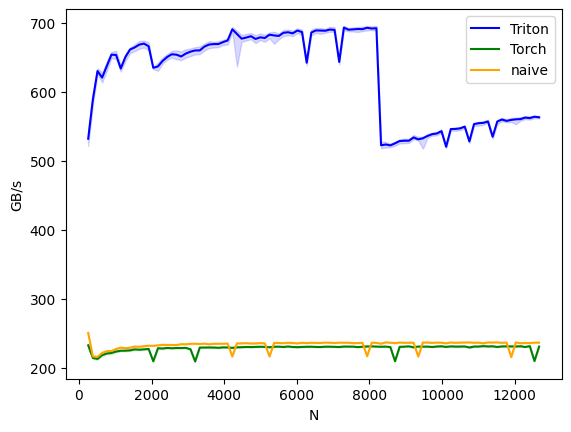

t_log_softmax_fwd:
          N      Triton       Torch       naive
0     256.0  532.092030  232.947861  250.775518
1     384.0  588.646738  214.754773  216.847060
2     512.0  630.153868  213.298622  216.171523
3     640.0  620.606079  218.818037  221.955296
4     768.0  637.303077  221.135617  224.481057
5     896.0  653.803337  221.905185  224.603183
6    1024.0  653.454110  223.943039  227.687320
7    1152.0  633.765027  225.123657  229.607744
8    1280.0  650.373808  225.209625  228.906729
9    1408.0  661.271391  225.656086  229.438584
10   1536.0  664.309744  227.095578  231.190186
11   1664.0  668.384935  226.607324  230.781394
12   1792.0  669.873959  227.161173  231.692927
13   1920.0  666.016232  227.713696  232.452125
14   2048.0  634.795291  209.813115  232.242746
15   2176.0  636.756697  228.770432  232.923521
16   2304.0  644.733817  228.348429  233.655350
17   2432.0  650.509700  229.160903  233.523071
18   2560.0  654.432861  228.746945  233.431866
19   2688.0  653.8032

In [10]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # Argument names to use as an x-axis for the plot.
        x_vals=[128 * i for i in range(2, 100)],  # Different possible values for `x_name`.
        #x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch', 'naive'],  # Possible values for `line_arg`.
        line_names=['Triton', 'Torch', 'naive'],  # Label name for the lines.
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='t_log_softmax_fwd',  # Name for the plot. Used also as a file name for saving the plot.
        args={'M':4096},  # Values for function arguments not in `x_names` and `y_name`.
        # TODO T: Use real M i.e. 
    ))
def benchmark(M, N, provider):
    dloss_dx = torch.rand(M, N, device="cuda", dtype=torch.float32)    
    x = torch.rand(M, N, device="cuda", dtype=torch.float32)
    stream = getattr(torch, "cuda").Stream() # TODO XXX XXX: what is this stream about?
    getattr(torch, "cuda").set_stream(stream)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        #ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_jit(x), quantiles=quantiles)
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_jit(dloss_dx, x), quantiles=quantiles)
    if provider == 'triton':
        #ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_t(x), quantiles=quantiles)        
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_t(dloss_dx, x), quantiles=quantiles)
    if provider == 'naive':
        #ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_naive(x), quantiles=quantiles)
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_naive(dloss_dx, x), quantiles=quantiles)
    gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)
benchmark.run(print_data=True, show_plots=True)

In [11]:
import torch
print(torch.cuda.get_device_properties("cuda"))
from triton.runtime import driver
device = torch.cuda.current_device()
properties = driver.active.utils.get_device_properties(device)
NUM_SM = properties["multiprocessor_count"]
SIZE_SMEM = properties["max_shared_mem"]
NUM_REGS = properties["max_num_regs"]
WARP_SIZE = properties["warpSize"] # Not 64 as A100
properties

_CudaDeviceProperties(name='NVIDIA A10G', major=8, minor=6, total_memory=22723MB, multi_processor_count=80, uuid=df82317b-d317-7368-eed6-8c8a4866f43b, L2_cache_size=6MB)


{'max_shared_mem': 101376,
 'max_num_regs': 65536,
 'multiprocessor_count': 80,
 'warpSize': 32,
 'sm_clock_rate': 1710000,
 'mem_clock_rate': 6251000,
 'mem_bus_width': 384}

In [1]:
num_stages = 4 if SIZE_SMEM > 200000 else 2
num_warps = 8
x_2d = aa.reshape((-1, aa.shape[-1])) # TODO T: without this reshape, this func is 2times faster
n_rows, n_cols = x_2d.shape
BLOCK_SIZE = triton.next_power_of_2(n_cols) 
output = torch.empty_like(x_2d)
print(f'num_stages', num_stages, 'num_warps', num_warps)

kernel = t_dropout_bkwd2_t.warmup(x_2d, True, 42, output, x_2d.stride(0), output.stride(0), n_rows, n_cols, BLOCK_SIZE=BLOCK_SIZE,
                                   num_stages=num_stages, num_warps=num_warps, grid=(1, ))
kernel._init_handles()
n_regs = kernel.n_regs
size_smem = kernel.metadata.shared
print(f'n_regs', n_regs, 'size_smem', size_smem)

occupancy = NUM_REGS // (n_regs * WARP_SIZE * num_warps)
size_smem = max(1, size_smem)
print(f'occupancy', occupancy, SIZE_SMEM // size_smem)
occupancy = min(occupancy, SIZE_SMEM // size_smem)
num_programs = NUM_SM * occupancy
print(f'num_programs', num_programs)

NameError: name 'SIZE_SMEM' is not defined

In [ ]:
32
2080
4128
6176